# Route planner for a road network

In [1]:
#pip install smopy

Note: you may need to restart the kernel to use updated packages.


In [1]:
#Install in the command line from conda distribution as admin...with:
#conda install gdal


In [1]:
#Impo9rt librearies...
import io
import zipfile
import requests
import networkx as nx
import numpy as np
import pandas as pd
import json
import smopy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#We load the data (a Shapefile dataset) with NetworkX. This dataset
#contains detailed information about the primary roads in California
# NetworkX's read_shp() function returns a graph, where each node is
#a geographical position
url = ('https://github.com/ipython-books/'
       'cookbook-2nd-data/blob/master/'
       'road.zip?raw=true')
r = io.BytesIO(requests.get(url).content)
zipfile.ZipFile(r).extractall('data')
g = nx.read_shp('data/tl_2013_06_prisecroads.shp')

In [3]:
#This graph is not necessarily connected, but we need a connected
#graph in order to compute shortest paths. Here, we take the largest
#connected subgraph using the connected_component_subgraphs() function
sgs = list(nx.connected_component_subgraphs(g.to_undirected()))
i = np.argmax([len(sg) for sg in sgs])
sg = sgs[i]
len(sg)

464

In [4]:
#We define two positions
#(with the latitude and longitude)
#and find the shortest path between these two positions:
pos0 = (36.6026, -121.9026)
pos1 = (34.0569, -118.2427)

In [5]:
#Each edge in the graph contains information about the road,
#including a list of points along this road. We first create
#a function that returns this array of coordinates, for any
#edge in the graph
def get_path(n0, n1):
    """If n0 and n1 are connected nodes in the graph,
    this function returns an array of point
    coordinates along the road linking these two
    nodes."""
    return np.array(json.loads(sg[n0][n1]['Json'])
                    ['coordinates'])

In [6]:
#We can notably use the road path to compute its length.
#We first need to define a function that computes the distance
#between any two points in geographical coordinates:
# from [https://stackoverflow.com/a/8859667/1595060]
#(https://stackoverflow.com/a/8859667/1595060)
EARTH_R = 6372.8

def geocalc(lat0, lon0, lat1, lon1):
    """Return the distance (in km) between two points
    in geographical coordinates."""
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    dlon = lon0 - lon1
    y = np.sqrt((np.cos(lat1) * np.sin(dlon)) ** 2 +
        (np.cos(lat0) * np.sin(lat1) - np.sin(lat0) *
         np.cos(lat1) * np.cos(dlon)) ** 2)
    x = np.sin(lat0) * np.sin(lat1) + \
        np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
    c = np.arctan2(y, x)
    return EARTH_R * c

In [7]:
#Now, we define a function computing a path's length
def get_path_length(path):
    return np.sum(geocalc(path[1:, 1], path[1:, 0],
                          path[:-1, 1], path[:-1, 0]))

In [8]:
#We update our graph by computing the distance between
#any two connected nodes. We add this information with
#the distance attribute of the edges
# Compute the length of the road segments.
for n0, n1 in sg.edges:
    path = get_path(n0, n1)
    distance = get_path_length(path)
    sg.edges[n0, n1]['distance'] = distance

In [9]:
#The last step before we can find the shortest path in the graph
#is to find the two nodes in the graph that are closest to the two
#requested positions
nodes = np.array(sg.nodes())
# Get the closest nodes in the graph.
pos0_i = np.argmin(
    np.sum((nodes[:, ::-1] - pos0)**2, axis=1))
pos1_i = np.argmin(
    np.sum((nodes[:, ::-1] - pos1)**2, axis=1))

In [10]:
#we use NetworkX's shortest_path() function to compute the shortest
#path between our two positions. We specify that the weight of every
#edge is the length of the road between them
# Compute the shortest path.
path = nx.shortest_path(
    sg,
    source=tuple(nodes[pos0_i]),
    target=tuple(nodes[pos1_i]),
    weight='distance')
len(path)

20

In [11]:
# The itinerary has been computed. The path variable contains the
#list of edges that form the shortest path between our two positions.
#Now, we can get information about the itinerary with pandas. 
#The dataset has a few fields of interest, including the name and type
#(State, Interstate, and so on) of the roads...
roads = pd.DataFrame(
    [sg.edges[path[i], path[i + 1]]
     for i in range(len(path) - 1)],
    columns=['FULLNAME', 'MTFCC',
             'RTTYP', 'distance'])
roads

,FULLNAME,MTFCC,RTTYP,distance
0,State Rte 1,S1200,S,119.835869
1,State Rte 1,S1200,S,37.559920
2,Cabrillo Hwy,S1200,M,4.412885
3,State Rte 1,S1200,S,13.486984
4,Cabrillo Hwy,S1200,M,37.244017
5,Cabrillo Hwy,S1200,M,0.021492
6,Cabrillo Hwy,S1200,M,0.468038
7,Cabrillo Hwy,S1200,M,0.165975
8,State Hwy 1,S1200,S,0.009908
9,el Camino Real,S1200,M,9.083219


In [12]:
#Here is the total length of this itinerary
roads['distance'].sum()

533.1490920162638

In [13]:
#Finally, let's display the itinerary on the map.
#We first retrieve the map with Smopy
m = smopy.Map(pos0, pos1, z=7, margin=.1)

In [14]:
#Our path contains connected nodes in the graph. Every edge between 
#two nodes is characterized by a list of points (constituting a part
#of the road). Therefore, we need to define a function that concatenates
#the positions along every edge in the path. We have to concatenate the
#positions in the right order along our path. We choose the order based on
#the fact that the last point in an edge needs to be close to the first point
#in the next edge
def get_full_path(path):
    """Return the positions along a path."""
    p_list = []
    curp = None
    for i in range(len(path) - 1):
        p = get_path(path[i], path[i + 1])
        if curp is None:
            curp = p
        if (np.sum((p[0] - curp) ** 2) >
                np.sum((p[-1] - curp) ** 2)):
            p = p[::-1, :]
        p_list.append(p)
        curp = p[-1]
    return np.vstack(p_list)

In [15]:
# We convert the path in pixels in order to display it on the Smopy map
linepath = get_full_path(path)
x, y = m.to_pixels(linepath[:, 1], linepath[:, 0])

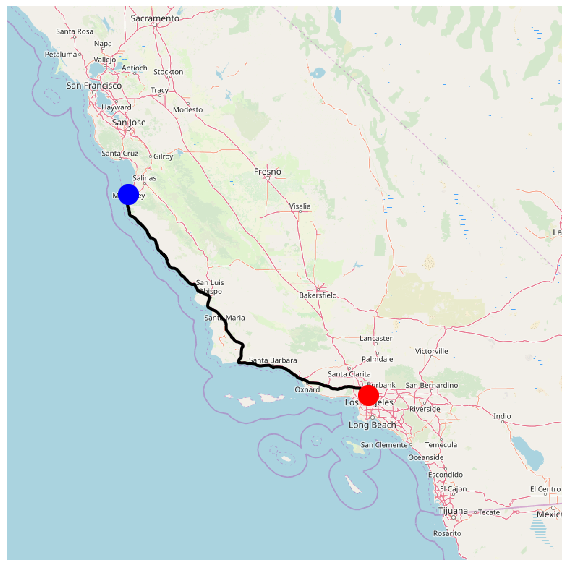

In [16]:
#Finally, let's display the map, with our two positions and the computed
#itinerary between them...
ax = m.show_mpl(figsize=(8, 8))
# Plot the itinerary.
ax.plot(x, y, '-k', lw=3)
# Mark our two positions.
ax.plot(x[0], y[0], 'ob', ms=20)
ax.plot(x[-1], y[-1], 'or', ms=20)